(500, 500)

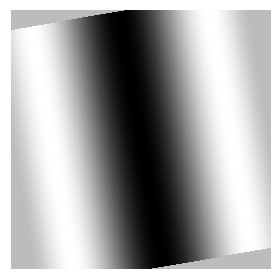

In [67]:
import math
import numpy as np
from scipy import signal as sg
import scipy
import  matplotlib.pyplot as plt
import scipy.sparse as spsp
from mpl_toolkits.mplot3d import Axes3D
#from PIL import Image
import time
from scipy.ndimage import rotate
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


def rgb2gray(Img):
    return 0.2989 * Img[:,:,0] + 0.5870 * Img[:,:,1] + 0.1140 * Img[:,:,2] 

def Convol(img):
    shape=[5,5]
    sigma=1
    m,n = (shape[0]-1)/2,(shape[1]-1)/2
    y,x = np.ogrid[-m:m+1,-n:n+1]
    res = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    Sum = res.sum()
    
    """normalization"""
    res/=Sum
    
    return np.array(sg.convolve(img,res,mode="same"))
  
def gradient(img):
    g=np.gradient(img)
    
    return np.array(g[0]),np.array(g[1])

#Create surface

def F(x):
    return (x*x-4)*(x*x-9)*(x*x-16)/36

def f(x):
    return 1./18*(3*(x**4)-58*(x*x)+244)*x


def initrayure(nbpixels=30):
    x = np.linspace(-3.626,3.626,nbpixels)
    rayure = F(x)
    rayure -= rayure[0]
    return rayure

def plot3d(Imgrayure):
    x,y=Imgrayure.shape
    Y = np.arange(0,x/50,0.02)
    X = np.arange(0,y/50,0.02)
    X, Y = np.meshgrid(X, Y)   
    Z = np.array(Imgrayure)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    #ax.plot_surface(X,Y,Z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    
def createrayure(width,length,ifplot=0,angle=45):
    rayure = initrayure(width)
    Imgrayure = [rayure]
    
    for i in range(length-1):
        Imgrayure=np.concatenate((Imgrayure,[rayure]))
   
    if angle!=0:
        Imgrayure = rotate(Imgrayure, 1.0*angle, reshape=False)
    if ifplot:
        plt.imshow(Imgrayure, cmap='gray')
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
      
    return Imgrayure

#grow a area with value 0 by 1 pixel
def grow(u0):
    X,Y=u0.shape
    res=np.ones_like(u0)
    for x in range(1,X-1):
        for y in range(1,Y-1):
            if u0[x,y]==0:
                res[x-1][y-1]=0
                res[x-1][y]=0
                res[x-1][y+1]=0
                res[x][y]=0
                res[x][y-1]=0
                res[x][y+1]=0
                res[x+1][y-1]=0
                res[x+1][y]=0
                res[x+1][y+1]=0
    return res   
#save pic with no white margin
def savefig(img,name='result.png'):
    #1 channel image
    fig, ax = plt.subplots() 
    im = img
    ax.imshow(im) 
    plt.axis('off') 

    height, width= im.shape 
    
    fig.set_size_inches(width/50.0, height/50.0) 
    plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
    plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
    plt.margins(0,0)

    plt.savefig(name)
    
def create3kimage():
    res=np.zeros([3000,3000])
    
    rayure1=createrayure(50,500,0,30)
    [r,c]=rayure1.shape
    res[60:60+r,50:50+c]=rayure1/2
    
    rayure2=createrayure(50,800,0,60)
    [r,c]=rayure2.shape
    res[260:260+r,1500:1500+c]=rayure2*2
    
    rayure3=createrayure(100,400,0,-30)
    [r,c]=rayure3.shape
    res[2600:2600+r,1050:1050+c]=rayure3
    
    
    return res
#Imagetest = np.array(create3kimage())
Imagetest=createrayure(500,500,1,10)
np.savetxt('test.txt',list(Imagetest),fmt='%1.6f')
Imagetest.shape

In [60]:
a=np.array([[2],[2]])
b=np.array([1,2,3,4,5])
np.savetxt('test.txt',(list(a)+list(b)),fmt='%1.6f')

In [38]:
def levelset(Iter,nbimg,mu,Img,l=5,init=1,mul=1,ifplot=1):
    import time
    start = time.clock()
    Img = Img.astype(float)
    mean=np.mean(Img)
    #Img=Img-mean
    [row,col] = Img.shape

    phi = np.ones([row,col])
#   for i in range(0,row,row//k):
#       for j in range(0,col,col//k):
#         phi[i-l:i+l, j-l:j+l] = -1.
  
#definition de phi_0
    if init==1:    
        for i in range(0,row):
            for j in range(0,col):
                phi[i][j]=np.sin(i/(l*1.))*np.sin(j/(l*1.)) 
                #phi[i][j]=(-1)**((i+j)//2)
                u = phi  
    else:
        phi[1:row-1,1:col-1] = -1
        u=-phi  
  
  
  
    k=Iter//nbimg
    if ifplot>0:
        fig,ax=plt.subplots(nbimg+1,1,figsize=[6,nbimg*3+3])
        ax[0].imshow(phi)
        ax[0].axis('off')
    i=1
    for n in range(1,Iter):
        ux, uy = gradient(u);

        z = np.zeros(u.shape)
        M = 0

        c1 = np.sum(Img[u<M])/np.sum(1*(u<M))
        c2 = np.sum(Img[u>M])/np.sum(1*(u>M))

        spf = Img - (c1+mul*c2)/2;
        spf = np.array(spf)
        spf = spf/(np.max(np.abs(spf)))

        u = u + (mu*spf*np.sqrt(ux**2 + uy**2));
        
        if ifplot>0:
            if n%k==0:
                ax[i].contour(u, 0,)
                ax[i].imshow(u,cmap='gray')
                ax[i].axis('off')
                i+=1
                
        u = 1*(u>0) - 1*(u<0)
        u = Convol(u)
        
    if ifplot>0:
        ax[i].contour(u, 0)
        ax[i].imshow(Img,cmap='gray')
        ax[i].axis('off')
    end = time.clock()
    print(end-start)
    
    return u

93.29780499999993


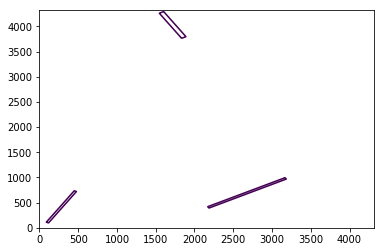

In [39]:
Img3 = plt.imread("result.png")
Img3 = rgb2gray(Img3)

nbditeration=2
nbimage=2
amp=100000
Imagetest=Img3
Phi_base=4
mode=1
multi=1
#ifplot=False
ifplot=False

u=levelset(nbditeration,nbimage,amp,Imagetest,Phi_base,mode,multi,ifplot)
plt.contour(u, 0)

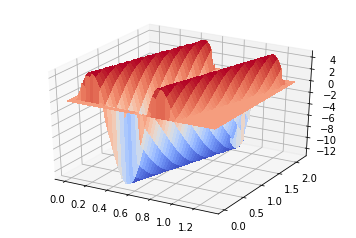

In [40]:
#creation d'une rayure

width=50
length=100
ifplot=False
angle=10

Imagerayure = createrayure(width,length,ifplot,angle)
plot3d(Imagerayure)

In [ ]:
savefig(Imagerayure,'res.png')

In [ ]:
Img3 = plt.imread("res.png")
Img3 = rgb2gray(Img3)
meanImg=np.mean(Img3)

u = levelset(20,2,10000,Img3,3,1,1.15,0)
ur = levelset(20,2,10000,Img3,3,1,1,0)

ur = ur-u

u0 = 0*(u>0) +1*(u<0)
ur = 1*(ur>0) +0*(ur<0)

u1 = grow(u0)
u2 = grow(u1)
u3 = grow(u2)
u4 = grow(u3)
u5 = grow(u4)
u6 = grow(u5)

plt.imshow(u1)
plt.imshow(u6)
meanImg = np.sum(Img3*ur)/np.sum(ur)

newimg3 = u6*Img3+meanImg*(1-u6)

In [ ]:
#enlever les fautes
plt.imshow(newimg3)
plt.show()
newimg3.shape


In [ ]:
#surface recunstructed
plot3d(newimg3)